Welcome to this assignment! During this week you saw how to create a model that will predict the next word in a text sequence, now you will implement such model and train it using a corpus of Shakespeare's sonnets, while also creating some helper functions to pre-process the data.

Let's get started!

In [47]:
import numpy as np 
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical 
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional, Input

In [4]:
!C:/ProgramData/Anaconda3/python.exe -m pip install gdown --upgrade pip

Defaulting to user installation because normal site-packages is not writeable
  Using cached pip-24.2-py3-none-any.whl.metadata (3.6 kB)
Using cached pip-24.2-py3-none-any.whl (1.8 MB)
  Attempting uninstall: pip
    Found existing installation: pip 23.3.2
    Uninstalling pip-23.3.2:
      Successfully uninstalled pip-23.3.2


  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.


In [7]:
!C:/ProgramData/Anaconda3/python.exe -m pip install gdown

Defaulting to user installation because normal site-packages is not writeable


In [8]:
import gdown
file_id = '108jAePKK4R3BVYBbYJZ32JWUwxeMg20K'
url = f'https://drive.google.com/uc?id={file_id}'
gdown.download(url, output=None, quiet=False)

Downloading...
From: https://drive.google.com/uc?id=108jAePKK4R3BVYBbYJZ32JWUwxeMg20K
To: C:\Users\HP\OneDrive\Bureau\next_word\sonnets.txt
100%|██████████████████████████████████████████████████████████████████████████████| 93.6k/93.6k [00:00<00:00, 980kB/s]


'sonnets.txt'

In [9]:
# Define path for file with sonnets
SONNETS_FILE = 'sonnets.txt'

# Read the data
with open('sonnets.txt') as f:
    data = f.read()

# Convert to lower case and save as a list
corpus = data.lower().split("\n")

print(f"There are {len(corpus)} lines of sonnets\n")
print(f"The first 5 lines look like this:\n")
for i in range(5):
  print(corpus[i])

There are 2159 lines of sonnets

The first 5 lines look like this:

from fairest creatures we desire increase,
that thereby beauty's rose might never die,
but as the riper should by time decease,
his tender heir might bear his memory:
but thou, contracted to thine own bright eyes,


# Tokenizing the text

Now fit the Tokenizer to the corpus and save the total number of words.

In [13]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(corpus)
total_words = len(tokenizer.word_index) + 1
print(total_words)

3211


When converting the text into sequences you can use the texts_to_sequences method as you have done throughout this course.

In the next graded function you will need to process this corpus one line at a time. Given this, it is important to keep in mind that the way you are feeding the data unto this method affects the result. Check the following example to make this clearer.

Notice that you received the sequence wrapped inside a list so in order to get only the desired sequence you need to explicitly get the first item in the list like this:

In [22]:
tokenizer.texts_to_sequences([corpus[0]])

[[34, 417, 877, 166, 213, 517]]

# Generating n_grams

Now complete the n_gram_seqs function below. This function receives the fitted tokenizer and the corpus (which is a list of strings) and should return a list containing the n_gram sequences for each line in the corpus:

In [25]:
# GRADED FUNCTION: n_gram_seqs
def n_gram_seqs(corpus, tokenizer):
    input_sequences = []
    
    ### START CODE HERE
    for line in corpus:
      token_list = tokenizer.texts_to_sequences([line])[0]

      for i in range(1, len(token_list)):
        n_gram_sequence = token_list[:i+1]

        input_sequences.append(n_gram_sequence)
    ### END CODE HERE
    
    return input_sequences
# Test your function with one example
first_example_sequence = n_gram_seqs([corpus[0]], tokenizer)

print("n_gram sequences for first example look like this:\n")
first_example_sequence

n_gram sequences for first example look like this:



[[34, 417],
 [34, 417, 877],
 [34, 417, 877, 166],
 [34, 417, 877, 166, 213],
 [34, 417, 877, 166, 213, 517]]

In [26]:
next_3_examples_sequence = n_gram_seqs(corpus[1:4], tokenizer)

print("n_gram sequences for next 3 examples look like this:\n")
next_3_examples_sequence

n_gram sequences for next 3 examples look like this:



[[8, 878],
 [8, 878, 134],
 [8, 878, 134, 351],
 [8, 878, 134, 351, 102],
 [8, 878, 134, 351, 102, 156],
 [8, 878, 134, 351, 102, 156, 199],
 [16, 22],
 [16, 22, 2],
 [16, 22, 2, 879],
 [16, 22, 2, 879, 61],
 [16, 22, 2, 879, 61, 30],
 [16, 22, 2, 879, 61, 30, 48],
 [16, 22, 2, 879, 61, 30, 48, 634],
 [25, 311],
 [25, 311, 635],
 [25, 311, 635, 102],
 [25, 311, 635, 102, 200],
 [25, 311, 635, 102, 200, 25],
 [25, 311, 635, 102, 200, 25, 278]]

Apply the n_gram_seqs transformation to the whole corpus and save the maximum sequence length to use it later:

In [27]:
# Apply the n_gram_seqs transformation to the whole corpus
input_sequences = n_gram_seqs(corpus, tokenizer)

# Save max length 
max_sequence_len = max([len(x) for x in input_sequences])

print(f"n_grams of input_sequences have length: {len(input_sequences)}")
print(f"maximum length of sequences is: {max_sequence_len}")

n_grams of input_sequences have length: 15462
maximum length of sequences is: 11


# Add padding to the sequences

Now code the pad_seqs function which will pad any given sequences to the desired maximum length. Notice that this function receives a list of sequences and should return a numpy array with the padded sequences:

In [29]:
# GRADED FUNCTION: pad_seqs
def pad_seqs(input_sequences, maxlen):
    """
    Pads tokenized sequences to the same length
    
    Args:
        input_sequences (list of int): tokenized sequences to pad
        maxlen (int): maximum length of the token sequences
    
    Returns:
        padded_sequences (array of int): tokenized sequences padded to the same length
    """
    
    padded_sequences = pad_sequences(input_sequences, maxlen=maxlen, padding='pre')   
    return padded_sequences

In [30]:
first_padded_seq = pad_seqs(first_example_sequence, len(first_example_sequence))
first_padded_seq

array([[  0,   0,   0,  34, 417],
       [  0,   0,  34, 417, 877],
       [  0,  34, 417, 877, 166],
       [ 34, 417, 877, 166, 213],
       [417, 877, 166, 213, 517]])

In [31]:
# Test your function with the n_grams_seq of the next 3 examples
next_3_padded_seq = pad_seqs(next_3_examples_sequence, max([len(s) for s in next_3_examples_sequence]))
next_3_padded_seq

array([[  0,   0,   0,   0,   0,   0,   8, 878],
       [  0,   0,   0,   0,   0,   8, 878, 134],
       [  0,   0,   0,   0,   8, 878, 134, 351],
       [  0,   0,   0,   8, 878, 134, 351, 102],
       [  0,   0,   8, 878, 134, 351, 102, 156],
       [  0,   8, 878, 134, 351, 102, 156, 199],
       [  0,   0,   0,   0,   0,   0,  16,  22],
       [  0,   0,   0,   0,   0,  16,  22,   2],
       [  0,   0,   0,   0,  16,  22,   2, 879],
       [  0,   0,   0,  16,  22,   2, 879,  61],
       [  0,   0,  16,  22,   2, 879,  61,  30],
       [  0,  16,  22,   2, 879,  61,  30,  48],
       [ 16,  22,   2, 879,  61,  30,  48, 634],
       [  0,   0,   0,   0,   0,   0,  25, 311],
       [  0,   0,   0,   0,   0,  25, 311, 635],
       [  0,   0,   0,   0,  25, 311, 635, 102],
       [  0,   0,   0,  25, 311, 635, 102, 200],
       [  0,   0,  25, 311, 635, 102, 200,  25],
       [  0,  25, 311, 635, 102, 200,  25, 278]])

In [32]:
# Pad the whole corpus
input_sequences = pad_seqs(input_sequences, max_sequence_len)

print(f"padded corpus has shape: {input_sequences.shape}")

padded corpus has shape: (15462, 11)


# Split the data into features and labels

Before feeding the data into the neural network you should split it into features and labels. In this case the features will be the padded n_gram sequences with the last word removed from them and the labels will be the removed word.

Complete the features_and_labels function below. This function expects the padded n_gram sequences as input and should return a tuple containing the features and the one hot encoded labels.

Notice that the function also receives the total of words in the corpus, this parameter will be very important when one hot enconding the labels since every word in the corpus will be a label at least once.

In [39]:
def features_and_labels(input_sequences, total_words):
        """
    Generates features and labels from n-grams
    
    Args:
        input_sequences (list of int): sequences to split features and labels from
        total_words (int): vocabulary size
    
    Returns:
        features, one_hot_labels (array of int, array of int): arrays of features and one-hot encoded labels
    """
        
    features = input_sequences[:,:-1]
    labels = input_sequences[:,-1]
    one_hot_labels = to_categorical(labels, num_classes=total_words)
    return features, one_hot_labels

In [40]:
# Test your function with the padded n_grams_seq of the first example
first_features, first_labels = features_and_labels(first_padded_seq, total_words)

print(f"labels have shape: {first_labels.shape}")
print("\nfeatures look like this:\n")
first_features

labels have shape: (5, 3211)

features look like this:



array([[  0,   0,   0,  34],
       [  0,   0,  34, 417],
       [  0,  34, 417, 877],
       [ 34, 417, 877, 166],
       [417, 877, 166, 213]])

In [68]:
# Split the whole corpus
features, labels = features_and_labels(input_sequences, total_words)

print(f"features have shape: {features.shape}")
print(f"labels have shape: {labels.shape}")

features have shape: (15462, 10)
labels have shape: (15462, 3211)


# Create the model

Now you should define a model architecture capable of achieving an accuracy of at least 80%.

In [82]:
# GRADED FUNCTION: create_model
import tensorflow as tf

def create_model(total_words, max_sequence_len):
        """
    Creates a text generator model
    
    Args:
        total_words (int): size of the vocabulary for the Embedding layer input
        max_sequence_len (int): length of the input sequences
    
    Returns:
        model (tf.keras Model): the text generator model
    """
        
    inputs = Input(shape=(features.shape[1],))
    x = Embedding(total_words, 100, input_length=max_sequence_len-1)(inputs)
    x = Bidirectional(LSTM(100, return_sequences=True))(x)
    x = Bidirectional(LSTM(200, return_sequences=False))(x)
    x = Dense(total_words*6, activation='relu')(x)
    outputs = Dense(total_words, activation='softmax')(x)

    model = tf.keras.Model(inputs, outputs)

    model.compile(loss='categorical_crossentropy',
                  optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                  metrics=['accuracy'])
    


    return model


In [83]:
model = create_model(total_words, max_sequence_len)
model.summary()

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 10)]              0         
                                                                 
 embedding_5 (Embedding)     (None, 10, 100)           321100    
                                                                 
 bidirectional_10 (Bidirect  (None, 10, 200)           160800    
 ional)                                                          
                                                                 
 bidirectional_11 (Bidirect  (None, 400)               641600    
 ional)                                                          
                                                                 
 dense_10 (Dense)            (None, 19266)             7725666   
                                                                 
 dense_11 (Dense)            (None, 3211)              6186

In [84]:
from tensorflow.keras.callbacks import ModelCheckpoint
# Define the checkpoint directory and filename
checkpoint_filepath = 'checkpoints_next_word_prediction/model_checkpoint.h5'

# Create ModelCheckpoint callback
checkpoint = ModelCheckpoint(filepath=checkpoint_filepath,
                             save_weights_only=True,  # Save only weights
                             monitor='val_loss',      # You can monitor another metric if preferred
                             mode='min',              # Use 'min' for minimizing loss
                             save_best_only=False,    # Save after every epoch
                             verbose=1)


# Train the model
history = model.fit(features, labels, verbose=1, epochs=50, callbacks=[checkpoint])

Epoch 1/50
484/484 [==============================] - ETA: 0s - loss: 6.7798 - accuracy: 0.0239
Epoch 1: saving model to checkpoints_next_word_prediction\model_checkpoint.h5
484/484 [==============================] - 343s 695ms/step - loss: 6.7798 - accuracy: 0.0239
Epoch 2/50
484/484 [==============================] - ETA: 0s - loss: 6.3845 - accuracy: 0.0329
Epoch 2: saving model to checkpoints_next_word_prediction\model_checkpoint.h5
484/484 [==============================] - 342s 706ms/step - loss: 6.3845 - accuracy: 0.0329
Epoch 3/50
484/484 [==============================] - ETA: 0s - loss: 6.1196 - accuracy: 0.0442
Epoch 3: saving model to checkpoints_next_word_prediction\model_checkpoint.h5
484/484 [==============================] - 324s 669ms/step - loss: 6.1196 - accuracy: 0.0442
Epoch 4/50
484/484 [==============================] - ETA: 0s - loss: 5.7835 - accuracy: 0.0583
Epoch 4: saving model to checkpoints_next_word_prediction\model_checkpoint.h5
484/484 [================

484/484 [==============================] - 320s 660ms/step - loss: 0.5610 - accuracy: 0.8425
Epoch 32/50
484/484 [==============================] - ETA: 0s - loss: 0.5520 - accuracy: 0.8452
Epoch 32: saving model to checkpoints_next_word_prediction\model_checkpoint.h5
484/484 [==============================] - 318s 658ms/step - loss: 0.5520 - accuracy: 0.8452
Epoch 33/50
484/484 [==============================] - ETA: 0s - loss: 0.5531 - accuracy: 0.8438
Epoch 33: saving model to checkpoints_next_word_prediction\model_checkpoint.h5
484/484 [==============================] - 319s 658ms/step - loss: 0.5531 - accuracy: 0.8438
Epoch 34/50
484/484 [==============================] - ETA: 0s - loss: 0.5586 - accuracy: 0.8410
Epoch 34: saving model to checkpoints_next_word_prediction\model_checkpoint.h5
484/484 [==============================] - 325s 672ms/step - loss: 0.5586 - accuracy: 0.8410
Epoch 35/50
484/484 [==============================] - ETA: 0s - loss: 0.5607 - accuracy: 0.8401
Epo

### To pass this assignment, your model should achieve a training accuracy of at least 80%

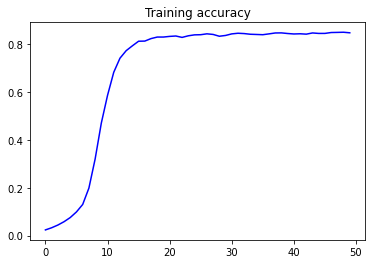

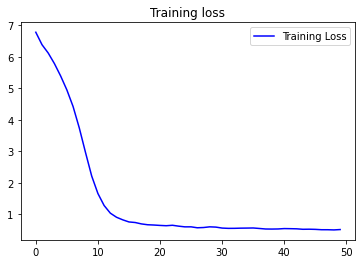

In [85]:
# Take a look at the training curves of your model

acc = history.history['accuracy']
loss = history.history['loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training accuracy')
plt.title('Training accuracy')

plt.figure()

plt.plot(epochs, loss, 'b', label='Training Loss')
plt.title('Training loss')
plt.legend()

plt.show()

In [87]:
def download_history():
    import pickle

    # Save the training history locally
    with open('history.pkl', 'wb') as f:
        pickle.dump(history.history, f)

    print("History saved locally as 'history.pkl'. You can find it in your working directory.")

# Call the function to save the history
download_history()


History saved locally as 'history.pkl'. You can find it in your working directory.


# See your model in action

After all your work it is finally time to see your model generating text.

Run the cell below to generate the next 100 words of a seed text.

In [88]:
seed_text = "Help me Obi Wan Kenobi, you're my only hope"
next_words = 100
  
for _ in range(next_words):
	# Convert the text into sequences
	token_list = tokenizer.texts_to_sequences([seed_text])[0]
	# Pad the sequences
	token_list = pad_sequences([token_list], maxlen=max_sequence_len-1, padding='pre')
	# Get the probabilities of predicting a word
	predicted = model.predict(token_list, verbose=0)
	# Choose the next word based on the maximum probability
	predicted = np.argmax(predicted, axis=-1).item()
	# Get the actual word from the word index
	output_word = tokenizer.index_word[predicted]
	# Append to the current text
	seed_text += " " + output_word

print(seed_text)

Help me Obi Wan Kenobi, you're my only hope my scythe and eyes her thee hid in wantonly dateless night days have seen his shade same doom and be seen afloat stand in the shore woe lies thee can well well befits thee in the spring of laws of his brow date date to her burn clearer his bough of spend ' strife afloat ghastly night her heart thereby fair imperfect shade appear new lies lies i be near you in my state or thee her mournful is my all my grief grief lies grief and befits her seal and meant thereby stand crown'd of thy sight to lie


### Congratulations on finishing this week's assignment!

You have successfully implemented a neural network capable of predicting the next word in a sequence of text!